<a href="https://colab.research.google.com/github/JinFree/PDE-for-CFD-in-Python/blob/master/Parabolic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parabolic PDE

## 확산방정식

* 확산방정식의 형태는 아래와 같음.
\begin{equation}
\frac{\partial{u}}{\partial{y}} = \nu \frac{\partial^{2}{u}}{\partial{y}^{2}}
\end{equation}
* Explicit FTCS 방법으로 푸는 예제임
 * FT = Forward Time
\begin{equation}
\frac{\partial{u}}{\partial{y}} = \frac{u_{i}^{n+1}-u_{i}^{n}}{\triangle{t}}
\end{equation}
 * CS = Central Space
\begin{equation}
\nu\frac{\partial^{2}{u}}{\partial{y}^{2}} = \nu\frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{{\triangle{y}}^2}
\end{equation}
* 정리하면 아래와 같음
\begin{equation}
u_{i}^{n+1} = du_{i+1}^{n} + (1-2d)u_{i}^{n}+du_{i-1}^{n}
\end{equation}
\begin{equation}
d = \frac{\nu\triangle{t}}{{\triangle{y}}^2}
\end{equation}
* 위의 방정식을 아래와 같은 조건으로 풀이함.
 * 환경 조건
\begin{equation}
0m<y<0.04m
\end{equation}
\begin{equation}
\nu = 0.000217m^2/s
\end{equation}
\begin{equation}
\triangle{t}=0.000001s
\end{equation}
\begin{equation}
\triangle{y}=0.001m
\end{equation}
 * 초기값 조건
\begin{equation}
u_{t=0} = 0m/s
\end{equation}
 * 경계 조건
\begin{equation}
u_{h=0m} = 40m/s
\end{equation}
\begin{equation}
u_{h=0.04m}=0m/s
\end{equation}


## 확산방정식 풀이를 위한 모듈 불러오기

In [0]:
import numpy as np

## 주어진 조건에 따른 기본 변수 설정

In [54]:
h = 0.04
nu = 0.00217
dy = 0.001
dt = 0.00001
u0 = 40.0
d = nu * dt / ( dy * dy )
t_end = 0.005
iteration = int(t_end / dt)
time = 0.0
number_of_grids = int(h / dy) + 1
U = np.zeros(number_of_grids, dtype=np.float32)
Unew = np.zeros(number_of_grids, dtype=np.float32)
print("Diffusion number is %.4f"%d)

Diffusion number is 0.0217


## 초기값 설정

In [0]:
def initial_condition(U, Unew):
    U = np.zeros(number_of_grids)
    Unew = np.zeros(number_of_grids)
    return U, Unew

## 경계 조건 설정

In [0]:
def boundary_condition(U, Unew):
    U[0] = Unew[0] = u0
    return U, Unew

## FTCS 연산 함수

In [0]:
def FTCS_Numpy(U, Unew, diffusion):
    U[0] = Unew[0] = u0
    for i in range(1, len(U)-1, 1):
        Unew[i] = diffusion * (U[i-1] + U[i+1]) + (1.0 - 2.0 * diffusion) * U[i]
    return Unew

def Explicit_Solver(U, Unew, diffusion, iteration, time):
    for i in range(iteration + 1):
        FTCS_Numpy(U, Unew, diffusion)
        U = np.copy(Unew)
        time += dt
 #       print("\rtime = %.6f" % time, end="")
 #   print()
    return U

## CPU기반 Numpy를 이용한 풀이 함수

In [55]:
def Parabolic_Numpy_CPU(U, Unew, diffusion, iteration, time):
    U, Unew = initial_condition(U, Unew)
    U, Unew = boundary_condition(U, Unew)
    U = Explicit_Solver(U, Unew, diffusion, iteration, time)
    return U
U_numpy_cpu = Parabolic_Numpy_CPU(U, Unew, d, iteration, time)

time = 0.005000


## 연산 결과를 plotting 하기 위한 함수

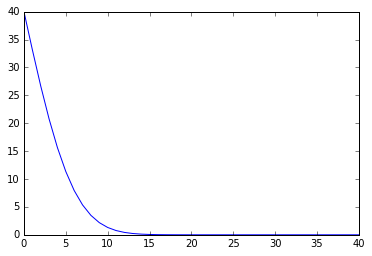

In [56]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
fig = plt.figure()
plt.plot(U_numpy_cpu)

In [59]:
%timeit U_numpy_cpu = Parabolic_Numpy_CPU(U, Unew, d, iteration, time)

100 loops, best of 3: 13.9 ms per loop
